## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [5]:
three = np.array(
    [
        [1, 2, 1],
        [
            1,
            3,
            5,
        ],
        [7, 1, 1],
    ]
)
start3 = 0
end3 = 8
four = np.array([[1, 2, 1, 6], [1, 3, 5, 3], [7, 1, 4, 1]])
start4 = 0
end4 = 11
five = np.array(
    [
        [1, 3, 7, 2, 1],
        [3, 1, 5, 3, 1],
        [3, 2, 6, 1, 2],
        [3, 1, 5, 6, 1],
        [2, 2, 1, 1, 2],
    ]
)
start5 = 10
end5 = 4

### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [10]:
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))
        self.startspike = False
        self.endspike = False

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        # determine if its spiked

        return self.history[0]


# Using this to prove generalizing
map = three
startloc = start3
endloc = end3
rows, columns = map.shape
print(rows, columns)
model = nengo.Network(label="Lab2", seed=123)
with model:
    # input spike
    spike = nengo.Node(Piecewise({0: 0, 0.25: 1, 0.75: 0}))

    # multi-dimensional neuron for map
    ensemble_map = nengo.Ensemble(n_neurons=map.size * 50, dimensions=map.size)

    # making delay node?
    dt = 0.001  # default nengo timestep
    for i in range(map.size):
        time_delay = 0.25  # seconds by which you wish to delay the signal
        delay = Delay(1, timesteps=int(time_delay / dt))

    nengo.Connection(spike, ensemble_map[startloc])

    # Connections (terrible)

    for i in range(rows):
        for j in range(columns):
            # n for current neuron 1-d location
            n = i * rows + j
            print(n)
            print(i, j)
            # indices for 2-d location
            downrow = i + 1
            uprow = i - 1
            leftcol = j - 1
            rightcol = j + 1
            # 1-d locations of 8 neighbors
            tl = uprow * rows + leftcol
            tm = uprow * rows + j
            tr = uprow * rows + rightcol
            ml = i * rows + leftcol
            mr = i * rows + rightcol
            bl = downrow * rows + leftcol
            bm = downrow * rows + j
            br = downrow * rows + rightcol

            # 8 connections (wrt to center of 3x3: tl tm tr, ml, mr, bl, bm, br)
            # checking for valid 2-d indices but connecting 1-d locations
            if uprow >= 0 and leftcol >= 0:
                nengo.Connection(ensemble_map[n], delay_list[tl])
                print("loc{} is connected to tl at {}".format(n, tl))
            if uprow >= 0:
                nengo.Connection(ensemble_map[n], delay_list[tm])
                print("loc{} is connected to tm at {}".format(n, tm))
            if uprow >= 0 and rightcol < columns:
                nengo.Connection(ensemble_map[n], delay_list[tr])
                print("loc{} is connected to tr at {}".format(n, tr))
            if leftcol >= 0:
                nengo.Connection(ensemble_map[n], delay_list[ml])
                print("loc{} is connected to ml at {}".format(n, ml))
            if rightcol < columns:
                nengo.Connection(ensemble_map[n], delay_list[mr])
                print("loc{} is connected to mr at {}".format(n, mr))
            if downrow < rows and leftcol >= 0:
                nengo.Connection(ensemble_map[n], delay_list[bl])
                print("loc{} is connected to bl at {}".format(n, bl))
            if downrow < rows:
                nengo.Connection(ensemble_map[n], delay_list[bm])
                print("loc{} is connected to bm at {}".format(n, bm))
            if downrow < rows and rightcol < columns:
                nengo.Connection(ensemble_map[n], delay_list[br])
                print("loc{} is connected to br at {}".format(n, br))

3 4
0
0 0
loc0 is connected to mr at 1
loc0 is connected to bm at 4
loc0 is connected to br at 5
1
0 1
loc1 is connected to ml at 0
loc1 is connected to mr at 2
loc1 is connected to bl at 4
loc1 is connected to bm at 5
loc1 is connected to br at 6
2
0 2
loc2 is connected to ml at 1
loc2 is connected to mr at 3
loc2 is connected to bl at 5
loc2 is connected to bm at 6
loc2 is connected to br at 7
3
0 3
loc3 is connected to ml at 2
loc3 is connected to bl at 6
loc3 is connected to bm at 7
4
1 0
loc4 is connected to tm at 0
loc4 is connected to tr at 1
loc4 is connected to mr at 5
loc4 is connected to bm at 8
loc4 is connected to br at 9
5
1 1
loc5 is connected to tl at 0
loc5 is connected to tm at 1
loc5 is connected to tr at 2
loc5 is connected to ml at 4
loc5 is connected to mr at 6
loc5 is connected to bl at 8
loc5 is connected to bm at 9
loc5 is connected to br at 10
6
1 2
loc6 is connected to tl at 1
loc6 is connected to tm at 2
loc6 is connected to tr at 3
loc6 is connected to ml a

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

0
This is time step where the pulse first begins for loc 0: 1260
This time step occurs at approximately  1.26  seconds
1
This is time step where the pulse first begins for loc 1: 3269
This time step occurs at approximately  3.269  seconds
2
This is time step where the pulse first begins for loc 2: 4277
This time step occurs at approximately  4.277  seconds
3
This is time step where the pulse first begins for loc 3: 10285
This time step occurs at approximately  10.285  seconds
4
This is time step where the pulse first begins for loc 4: 2268
This time step occurs at approximately  2.2680000000000002  seconds
5
This is time step where the pulse first begins for loc 5: 4268
This time step occurs at approximately  4.268  seconds
6
This is time step where the pulse first begins for loc 6: 8274
This time step occurs at approximately  8.274000000000001  seconds
7
This is time step where the pulse first begins for loc 7: 7285
This time step occurs at approximately  7.285  seconds
8
This is time

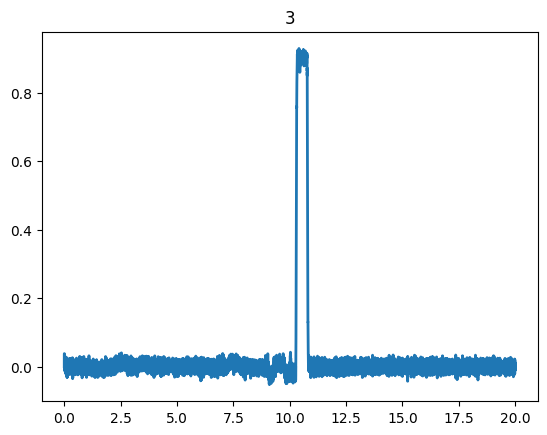

In [11]:
# not in nengo (work in progress)

for i in neuron_probe:
    aer = sim.data[neuron_probe][:, i] > 0.25
    spikes_locs = np.where(aer == True)
    first_spike = np.min(spikes_locs)

    print(
        "This is time step where the pulse first begins for loc {}: {}".format(
            i, first_spike
        )
    )

    dt = 0.001  # default nengo timestep
    print("This time step occurs at approximately ", first_spike * dt, " seconds")

### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path

[0, 4, 9, 10, 11]
